# Import lib

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report

import pathlib
import PIL
import PIL.Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping

tf.__version__

'2.4.1'

In [3]:
seed = 123
np.random.seed(seed)

# Import the data. Analyse the dimensions of the data. Visualise the data

In [4]:
ROOT_PATH = "D:\\01_BALAJI\\01_MLAI\\MLAI\\11_ComputerVision\\Assignment"

In [5]:
data_dir = pathlib.Path(os.path.join(ROOT_PATH,"Part1_data","train"))
totaltrainimage = 0
for path in data_dir.iterdir():
    imagelist = list(data_dir.glob(path.name+'/*'))
    print(path.name,len(imagelist))
    #PIL.Image.open(str(imagelist[0]))
    totaltrainimage = totaltrainimage + len(list(data_dir.glob(path.name+'/*')))
    
print("Total Train image --- ",totaltrainimage)


Black-grass 263
Charlock 390
Cleavers 287
Common Chickweed 611
Common wheat 221
Fat Hen 475
Loose Silky-bent 672
Maize 221
Scentless Mayweed 516
Shepherds Purse 231
Small-flowered Cranesbill 496
Sugar beet 385
Total Train image ---  4768


In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
# Create data generator for training data with data augmentation and normalizing all
# values by 255
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


training_set = train_datagen.flow_from_directory(data_dir,
                                                 target_size = (img_height, img_width),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',                                              
                                                 subset="training",
                                                 seed = 123
                                                )

# Setting testing data generator's source directory
validation_set = val_datagen.flow_from_directory(data_dir,
                                                 target_size = (img_height, img_width),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',                                              
                                                 subset="validation",
                                                 seed = 123
                                                )


Found 3817 images belonging to 12 classes.
Found 951 images belonging to 12 classes.


In [8]:
train_class_name = list(training_set.class_indices.keys())
train_class_value = list(training_set.class_indices.values())
print(training_set.class_indices)
plt.figure(figsize=(10, 10))
image,label = training_set.next()
print("Shape of the train image ( single batch ) -  " ,image.shape)

{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
Shape of the train image ( single batch ) -   (32, 180, 180, 3)


<Figure size 720x720 with 0 Axes>

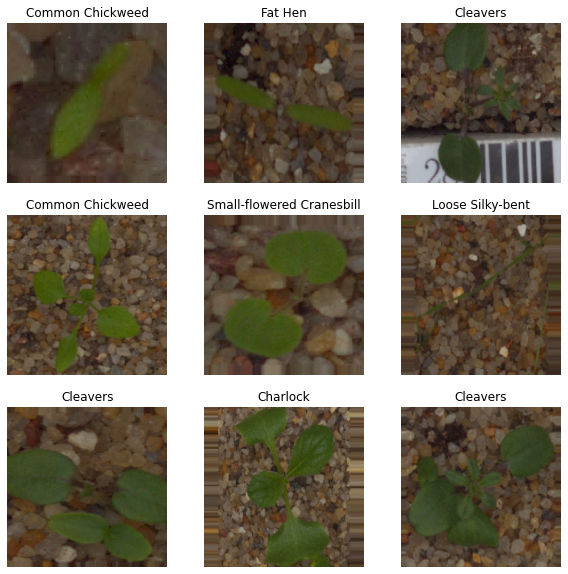

In [9]:
# Visualize the image ( Train image)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    plt.title(train_class_name[list(label[i]).index(1)])
    plt.axis("off")

In [10]:
validate_class_name = list(validation_set.class_indices.keys())
validate_class_value = list(validation_set.class_indices.values())
print(validation_set.class_indices)
plt.figure(figsize=(10, 10))
image,label = validation_set.next()
print("Shape of the validate image ( single batch ) -  " ,image.shape)


{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
Shape of the validate image ( single batch ) -   (32, 180, 180, 3)


<Figure size 720x720 with 0 Axes>

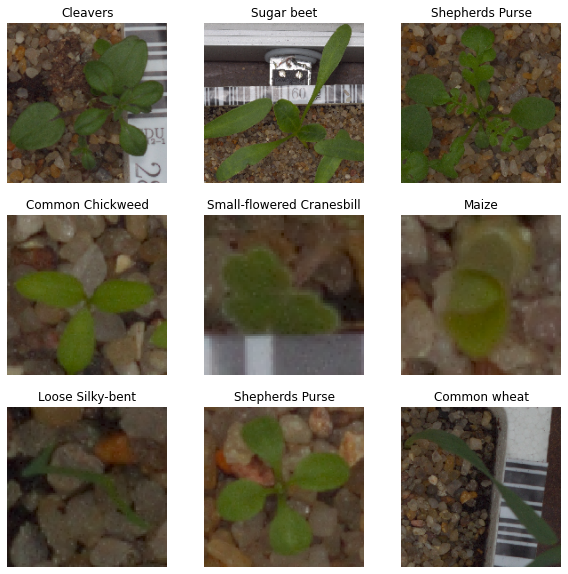

In [11]:
# Visualize the image ( Validate image )
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    plt.title(validate_class_name[list(label[i]).index(1)])
    plt.axis("off")

#  supervised learning algorithms Vs NN Vs CNN
 - Sample data is selected and trained and tested using supervised learning algorithms Vs NN Vs CNN

In [12]:
X_train=np.concatenate([training_set.next()[0] for i in range(training_set.__len__())])
y_train=np.concatenate([training_set.next()[1]  for i in range(training_set.__len__())])
print(X_train.shape)
print(y_train.shape)

(3817, 180, 180, 3)
(3817, 12)


In [13]:
y_train_sl = np.argmax(y_train, axis=1)
print(y_train_sl.shape)

(3817,)


In [14]:
X_val=np.concatenate([validation_set.next()[0] for i in range(validation_set.__len__())])
y_val=np.concatenate([validation_set.next()[1]  for i in range(validation_set.__len__())])
print(X_val.shape)
print(y_val.shape)

(951, 180, 180, 3)
(951, 12)


In [15]:
y_val_sl = np.argmax(y_val, axis=1)
print(y_val_sl.shape)

(951,)


In [16]:
X_train_sl = X_train.reshape(X_train.shape[0],3*img_width*img_height)
X_train_sl.shape

(3817, 97200)

In [17]:
X_val_sl = X_val.reshape(X_val.shape[0],3*img_width*img_height)
X_val_sl.shape

(951, 97200)

## Training using - KNeighborsClassifier

In [35]:
k_vals = [1,5,7,11]
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_sl, y_train_sl)
    print("K Value - ",k,"Train Accuracy - ",round(knn.score(X_train_sl, y_train_sl)),"Val Accuracy - ",knn.score(X_val_sl, y_val_sl)) 

K Value -  1 Train Accuracy -  1 Val Accuracy -  0.10620399579390116
K Value -  5 Train Accuracy -  0 Val Accuracy -  0.10620399579390116
K Value -  7 Train Accuracy -  0 Val Accuracy -  0.11461619348054679
K Value -  11 Train Accuracy -  0 Val Accuracy -  0.11251314405888538


## Training using - NN

In [20]:
def nn_model_dropout(kernel_initializer = "normal"):
    model = Sequential()
    #model.add(Flatten())
    model.add(Dense(units = 512,input_shape = (97200, ),kernel_initializer=kernel_initializer,activation = 'sigmoid'))
    model.add(Dense(units = 128,kernel_initializer=kernel_initializer, activation = 'relu'))
    model.add(Dense(units = 64,kernel_initializer=kernel_initializer, activation = 'sigmoid'))
    model.add(Dense(units = 32,kernel_initializer=kernel_initializer, activation = 'relu'))
    model.add(Dense(units = 12, activation = 'softmax'))
    return model


model_drop = nn_model_dropout(kernel_initializer="he_normal")
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
es = EarlyStopping(monitor='val_loss', patience=5,min_delta=0.01)
model_drop.compile(optimizer = "sgd", loss = 'categorical_crossentropy', metrics = ['accuracy'])
fit_data = model_drop.fit(X_train_sl, y_train, validation_data=(X_val_sl,y_val),batch_size = 64, epochs = 10, verbose = 1,callbacks=[es])



Epoch 1/10
60/60 [==============================] - 15s 238ms/step - loss: 2.5549 - accuracy: 0.1215 - val_loss: 2.4356 - val_accuracy: 0.1472
Epoch 2/10
60/60 [==============================] - 14s 234ms/step - loss: 2.4326 - accuracy: 0.1299 - val_loss: 2.4194 - val_accuracy: 0.1451
Epoch 3/10
60/60 [==============================] - 14s 240ms/step - loss: 2.4185 - accuracy: 0.1415 - val_loss: 2.4144 - val_accuracy: 0.1462
Epoch 4/10
60/60 [==============================] - 15s 243ms/step - loss: 2.4192 - accuracy: 0.1410 - val_loss: 2.4124 - val_accuracy: 0.1441
Epoch 5/10
60/60 [==============================] - 14s 236ms/step - loss: 2.4170 - accuracy: 0.1240 - val_loss: 2.4132 - val_accuracy: 0.1430
Epoch 6/10
60/60 [==============================] - 14s 236ms/step - loss: 2.4082 - accuracy: 0.1397 - val_loss: 2.4124 - val_accuracy: 0.1451
Epoch 7/10
60/60 [==============================] - 14s 236ms/step - loss: 2.4158 - accuracy: 0.1456 - val_loss: 2.4128 - val_accuracy: 0.1451

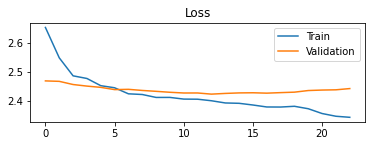

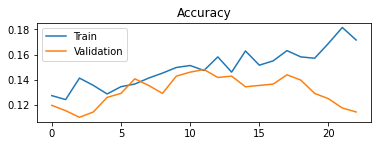

In [43]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(fit_data.history['loss'],label="Train")
plt.plot(fit_data.history['val_loss'],label="Validation")
plt.legend()
plt.show()

# plot loss during training
plt.subplot(211)
plt.title('Accuracy')
plt.plot(fit_data.history['accuracy'],label="Train")
plt.plot(fit_data.history['val_accuracy'],label="Validation")

plt.legend()
plt.show()

## Training using - CNN

In [22]:
def cnn_model():
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, (3, 3), input_shape = (img_height, img_width, 3), activation = 'relu', padding = 'same'))
    cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
    cnn_model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
    cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
    cnn_model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
    cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
    
    ## Fully connected layer
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units = 512, activation = 'relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(units = 128, activation = 'relu'))
    cnn_model.add(Dense(units = 12, activation = 'softmax'))
    return cnn_model


cnn_model = cnn_model()
optimizer = SGD(learning_rate=0.01,momentum=0.9)
es = EarlyStopping(monitor='val_loss', patience=5,min_delta=0.01)
cnn_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
fit_data = cnn_model.fit_generator(training_set,
                         steps_per_epoch = int(3817/32),
                         epochs = 500,
                         validation_data = validation_set,
                         validation_steps = int(951/32))

Epoch 1/500
119/119 [==============================] - 185s 2s/step - loss: 2.4424 - accuracy: 0.1362 - val_loss: 2.4064 - val_accuracy: 0.1412
Epoch 2/500
119/119 [==============================] - 179s 2s/step - loss: 2.3696 - accuracy: 0.1721 - val_loss: 1.8113 - val_accuracy: 0.3718
Epoch 3/500
119/119 [==============================] - 187s 2s/step - loss: 1.8882 - accuracy: 0.3485 - val_loss: 1.8035 - val_accuracy: 0.3847
Epoch 4/500
119/119 [==============================] - 220s 2s/step - loss: 1.6921 - accuracy: 0.4094 - val_loss: 1.5008 - val_accuracy: 0.4515
Epoch 5/500
119/119 [==============================] - 181s 2s/step - loss: 1.5364 - accuracy: 0.4533 - val_loss: 1.3192 - val_accuracy: 0.5517
Epoch 6/500
119/119 [==============================] - 179s 2s/step - loss: 1.3905 - accuracy: 0.5270 - val_loss: 1.2257 - val_accuracy: 0.5830
Epoch 7/500
119/119 [==============================] - 180s 2s/step - loss: 1.2479 - accuracy: 0.5610 - val_loss: 0.9920 - val_accuracy:

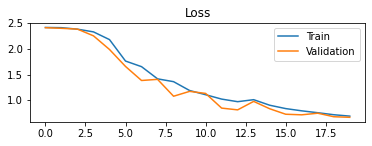

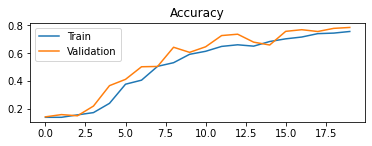

In [52]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(fit_data.history['loss'],label="Train")
plt.plot(fit_data.history['val_loss'],label="Validation")
plt.legend()
plt.show()

# plot loss during training
plt.subplot(211)
plt.title('Accuracy')
plt.plot(fit_data.history['accuracy'],label="Train")
plt.plot(fit_data.history['val_accuracy'],label="Validation")

plt.legend()
plt.show()